In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from typing import Callable
from tqdm.auto import tqdm

In [91]:
def to_points(x, N=None, d=None):
    """Accepts x as (N,d) array or flat (N*d,) vector."""
    x = np.asarray(x, dtype=float)
    if x.ndim == 2:
        return x
    if x.ndim == 1:
        assert N is not None and d is not None, "For flat x, provide N and d."
        return x.reshape(N, d)
    raise ValueError("x must be a flat vector or an (N,d) array.")


def plot_configuration_2d(points: np.ndarray, r_min=None, title=None):
    fig, ax = plt.subplots()

    ax.scatter(points[:, 0], points[:, 1])
    for i, (px, py) in enumerate(points):
        ax.text(px, py, str(i), ha="left", va="bottom")

    if r_min is not None:
        rad = 0.5 * float(r_min)
        for px, py in points:
            ax.add_patch(Circle((px, py), rad, fill=False))

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25)
    plt.show()

    return ax


def plot_configuration_3d(points: np.ndarray, r_min=None, title=None):
    N = points.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(points[:, 0], points[:, 1], points[:, 2])  # type: ignore

    for j in range(N):
        for k in range(j + 1, N):
            xs = [points[j, 0], points[k, 0]]
            ys = [points[j, 1], points[k, 1]]
            zs = [points[j, 2], points[k, 2]]
            ax.plot(xs, ys, zs, alpha=0.5)

    # if r_min is not None:

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.show()

    return ax

In [92]:
def softplus(z):
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def unpack(x, N, d):
    return x.reshape(N, d)


def objective(
    x: np.ndarray,
    N: int,
    d: int,
    eps: float = 1.0,
    sigma: float = 1.0,
    r_min: float = 0.9,
    mu_sep: float = 10.0,
    lam_com: float = 10.0,
):
    P = unpack(x, N, d)
    J = 0.0
    G = np.zeros_like(P)

    # Center of mass penalty
    com = P.mean(axis=0)
    J += lam_com * (com @ com)
    G += (2.0 * lam_com / N) * com

    for i in range(N):
        for j in range(i + 1, N):
            rij_vec = P[i] - P[j]
            r = np.linalg.norm(rij_vec) + 1e-9

            # Lennard-Jones Energy
            sr = sigma / r
            sr6 = sr**6
            sr12 = sr6**2
            V = 4.0 * eps * (sr12 - sr6)
            J += V
            dV_dr = 24.0 * eps * (-2.0 * (sigma**12) / (r**13) + (sigma**6) / (r**7))

            # Sep penalty: softplus(r_min - r)^2
            u = r_min - r
            sp = softplus(u)
            J += mu_sep * (sp * sp)
            dsep_dr = mu_sep * (-2.0 * sp * sigmoid(u))

            grad_vec = (dV_dr + dsep_dr) * (rij_vec / r)
            G[i] += grad_vec
            G[j] -= grad_vec

    return J, G.reshape(-1)

In [93]:
def strong_wolfe_line_search(
    xk: np.ndarray,
    pk: np.ndarray,
    f: Callable,
    grad_f: Callable,
    c1=1e-3,
    c2=0.9,
    alpha_1=1.0,
    alpha_max=50.0,
    max_iter=100,
):
    def phi(alpha: float) -> float:
        return f(xk + alpha * pk)

    def dphi(alpha: float) -> float:
        return grad_f(xk + alpha * pk).dot(pk)

    phi0, dphi0 = phi(0.0), dphi(0.0)
    # assert dphi(0.0) < 0

    def zoom(alpha_low: float, alpha_high: float) -> float:
        a_j = (alpha_low + alpha_high / 2.0)
        for _ in range(max_iter):
            phi_aj = phi(a_j)
            phi_low = phi(alpha_low)
            if (phi_aj > phi0 + c1 * a_j * dphi0) or (phi_aj >= phi_low):
                alpha_high = a_j
            else:
                dphi_aj = dphi(a_j)
                if abs(dphi_aj) <= c2 * abs(dphi0):
                    return a_j
                if dphi_aj * (alpha_high - alpha_low) >= 0:
                    alpha_high = alpha_low
                alpha_low = a_j
            a_j = (alpha_low + alpha_high) / 2.0
        return a_j

    alpha_prev = 0.0
    alpha_curr = alpha_1
    phi_prev = phi0

    for i in range(max_iter):
        phi_a = phi(alpha_curr)
        if (phi_a > phi0 + c1 * alpha_curr * dphi0) or (phi_a >= phi_prev and i > 0):
            return zoom(alpha_prev, alpha_curr)
        dphi_a = dphi(alpha_curr)
        if abs(dphi_a) <= c2 * abs(dphi0):
            return alpha_curr
        if dphi_a >= 0.0:
            return zoom(alpha_prev, alpha_curr)

        alpha_prev, phi_prev = alpha_curr, phi_a
        alpha_curr = min(2.0 * alpha_curr, alpha_max)

    return alpha_curr


def quasi_newton_line_search(
    x0: np.ndarray,
    H0: np.ndarray,
    f: Callable,
    grad_f: Callable,
    c1=1e-3,
    c2=0.9,
    tol=1e-6,
    max_iter=1000,
):
    xk = np.array(x0, dtype=float)
    n = xk.size
    Hk = np.array(H0, dtype=float)
    I = np.eye(n)  # noqa: E741
    f_hist = [f(xk)]

    for _ in range(max_iter):
        gk = grad_f(xk)
        if np.linalg.norm(gk) < tol:
            break

        # 1) Compute search direction
        pk = -Hk.dot(gk)

        # 2) x_k <- x_k + alpha p_k
        alpha = strong_wolfe_line_search(
            xk=xk,
            pk=pk,
            f=f,
            grad_f=grad_f,
            c1=c1,
            c2=c2,
        )
        x_next = xk + alpha * pk
        g_next = grad_f(x_next)

        # 3) Compute s_k and y_k
        s = x_next - xk
        y = g_next - gk
        ys = y.dot(s)

        # 4) BFGS update (with safeguard)
        if ys > 1e-12:
            rho = 1.0 / ys
            V = I - rho * np.outer(s, y)
            Hk = V.dot(Hk).dot(V.T) + rho * np.outer(s, s)
        else:
            Hk = I.copy()

        xk = x_next
        f_hist.append(f(xk))

    return xk, np.array(f_hist, dtype=float)

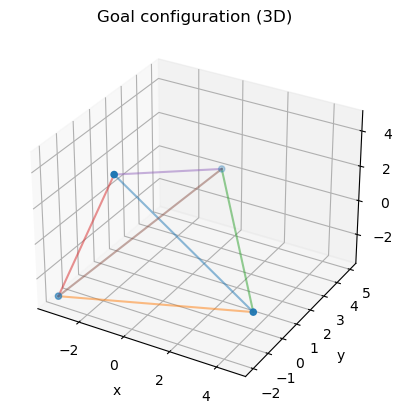

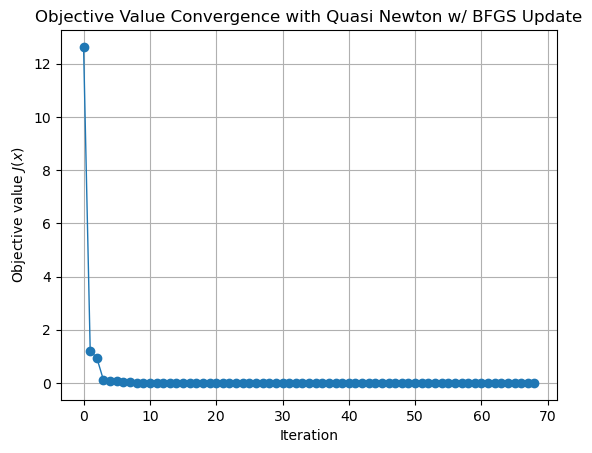

In [94]:
N = 4
d = 3
np.random.seed(15)
x0 = np.random.uniform(-1.5, 1.5, size=(N * d,))
H0 = np.eye(N * d)


def f(x):
    J, _ = objective(x, N, d)
    return J


def grad_f(x):
    _, g = objective(x, N, d)
    return g


x_star, f_hist = quasi_newton_line_search(x0=x0, H0=H0, f=f, grad_f=grad_f)
points = to_points(x_star, N=N, d=d)
plot_configuration_3d(points, r_min=1.0, title="Goal configuration (3D)")

plt.figure()
plt.plot(range(len(f_hist)), f_hist, marker="o", linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Objective value $J(x)$")
plt.title("Objective Value Convergence with Quasi Newton w/ BFGS Update")
plt.grid(True)
plt.show()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def is_feasible(x, N, d, r_min):
    P = x.reshape(N, d)
    for i in range(N):
        for j in range(i + 1, N):
            if np.linalg.norm(P[i] - P[j]) < r_min:
                return False
    return True

def edge_feasible(xa, xb, N, d, r_min, num_checks=20):
    for t in np.linspace(0.0, 1.0, num_checks):
        x = (1.0 - t) * xa + t * xb
        if not is_feasible(x, N, d, r_min):
            return False
    return True

def sample_free(bounds, n):
    low = np.array([b[0] for b in bounds], dtype=float)
    high = np.array([b[1] for b in bounds], dtype=float)
    return low + (high - low) * np.random.rand(n)

def steer(x_from, x_to, step_size):
    v = x_to - x_from
    dist = np.linalg.norm(v)
    if dist <= step_size:
        return x_to.copy()
    return x_from + (step_size / dist) * v

def nearest_index(X, x):
    D = np.linalg.norm(X - x[None, :], axis=1)
    return int(np.argmin(D))

def near_indices(X, x, radius):
    D = np.linalg.norm(X - x[None, :], axis=1)
    return np.where(D <= radius)[0].astype(int)

def extract_path(X, parent, goal_idx):
    path = []
    i = goal_idx
    while i != -1:
        path.append(X[i].copy())
        i = parent[i]
    path.reverse()
    return path

def rrt_star(
    x_start,
    x_goal,
    N,
    d,
    bounds,
    r_min,
    step_size=0.25,
    goal_radius=0.35,
    max_iters=20000,
    goal_sample_rate=0.05,
    near_radius=0.75,
    edge_checks=25,
    lam_energy = 0.5
):
    x_start = np.asarray(x_start, dtype=float).reshape(-1)
    x_goal = np.asarray(x_goal, dtype=float).reshape(-1)
    n = x_start.size

    if not is_feasible(x_start, N, d, r_min):
        raise ValueError("Start is infeasible.")
    if not is_feasible(x_goal, N, d, r_min):
        raise ValueError("Goal is infeasible.")

    max_nodes = 2 * max_iters + 2
    X = np.zeros((max_nodes, n), dtype=float)
    parent = -np.ones(max_nodes, dtype=int)
    cost = np.full(max_nodes, np.inf, dtype=float)

    X[0] = x_start
    parent[0] = -1
    cost[0] = 0.0
    size = 1

    best_goal_idx = -1
    best_goal_cost = np.inf

    for it in tqdm(range(max_iters), desc="RRT* planning", leave=True):
        if np.random.rand() < goal_sample_rate:
            x_rand = x_goal.copy()
        else:
            x_rand = sample_free(bounds, n)

        nn = nearest_index(X[:size], x_rand)
        x_new = steer(X[nn], x_rand, step_size)

        if not is_feasible(x_new, N, d, r_min):
            continue
        if not edge_feasible(X[nn], x_new, N, d, r_min, num_checks=edge_checks):
            continue

        near = near_indices(X[:size], x_new, near_radius)
        best_parent = nn
        mid = 0.5 * (x_new + X[nn])
        energy_mid = f(mid)          
        best_c = cost[nn] + np.linalg.norm(x_new - X[nn]) + lam_energy * energy_mid

        for j in near:
            if not np.isfinite(cost[j]):
                continue
            c_try = cost[j] + np.linalg.norm(x_new - X[j])
            if c_try < best_c:
                if edge_feasible(X[j], x_new, N, d, r_min, num_checks=edge_checks):
                    best_c = c_try
                    best_parent = j

        X[size] = x_new
        parent[size] = best_parent
        cost[size] = best_c
        new_idx = size
        size += 1

        for j in near:
            if j == best_parent:
                continue
            c_rewire = cost[new_idx] + np.linalg.norm(X[j] - X[new_idx])
            if c_rewire < cost[j]:
                if edge_feasible(X[new_idx], X[j], N, d, r_min, num_checks=edge_checks):
                    parent[j] = new_idx
                    cost[j] = c_rewire

        dist_to_goal = np.linalg.norm(x_new - x_goal)
        if dist_to_goal <= goal_radius:
            if edge_feasible(x_new, x_goal, N, d, r_min, num_checks=edge_checks):
                goal_idx = size
                X[goal_idx] = x_goal
                parent[goal_idx] = new_idx
                cost[goal_idx] = cost[new_idx] + np.linalg.norm(x_goal - x_new)
                size += 1
                if cost[goal_idx] < best_goal_cost:
                    best_goal_cost = cost[goal_idx]
                    best_goal_idx = goal_idx

    if best_goal_idx == -1:
        return None, {"nodes": X[:size], "parent": parent[:size], "cost": cost[:size]}

    path = extract_path(X[:size], parent[:size], best_goal_idx)
    return path, {"nodes": X[:size], "parent": parent[:size], "cost": cost[:size], "goal_idx": best_goal_idx}

def animate_path_gif_2d(path, N, d, r_min=None, filename="rrt_star_path.gif", interval=80):
    path = [np.asarray(x, dtype=float).reshape(-1) for x in path]
    P0 = path[0].reshape(N, d)
    if d != 2:
        raise ValueError("GIF animator below is 2D only. Use your 3D plotter for d=3.")

    all_pts = np.vstack([x.reshape(N, d) for x in path])
    xmin, ymin = all_pts.min(axis=0) - 0.5
    xmax, ymax = all_pts.max(axis=0) + 0.5

    fig, ax = plt.subplots()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.25)
    scat = ax.scatter(P0[:, 0], P0[:, 1])

    texts = []
    for i in range(N):
        t = ax.text(P0[i, 0], P0[i, 1], str(i), ha="left", va="bottom")
        texts.append(t)

    circles = []
    if r_min is not None:
        rad = 0.5 * float(r_min)
        for i in range(N):
            c = plt.Circle((P0[i, 0], P0[i, 1]), rad, fill=False)
            ax.add_patch(c)
            circles.append(c)

    def update(k):
        P = path[k].reshape(N, d)
        scat.set_offsets(P[:, :2])
        for i in range(N):
            texts[i].set_position((P[i, 0], P[i, 1]))
            if circles:
                circles[i].center = (P[i, 0], P[i, 1])
        ax.set_title(f"Step {k+1}/{len(path)}")
        return [scat, *texts, *circles]

    anim = FuncAnimation(fig, update, frames=len(path), interval=interval, blit=False)
    anim.save(filename, writer=PillowWriter(fps=max(1, int(1000 / interval))))
    plt.close(fig)
    return filename

from mpl_toolkits.mplot3d import Axes3D

def animate_path_gif_3d(path, N, d, r_min=None, filename="rrt_star_path_3d.gif", interval=80, elev=20, azim=45):
    path = [np.asarray(x, dtype=float).reshape(-1) for x in path]
    if d != 3:
        raise ValueError("This animator is 3D only (d must be 3).")

    all_pts = np.vstack([x.reshape(N, d) for x in path])
    mins = all_pts.min(axis=0) - 0.5
    maxs = all_pts.max(axis=0) + 0.5

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])
    ax.set_box_aspect((maxs[0]-mins[0], maxs[1]-mins[1], maxs[2]-mins[2]))
    ax.view_init(elev=elev, azim=azim)

    P0 = path[0].reshape(N, d)
    scat = ax.scatter(P0[:, 0], P0[:, 1], P0[:, 2])

    texts = []
    for i in range(N):
        texts.append(ax.text(P0[i, 0], P0[i, 1], P0[i, 2], str(i)))

    spheres = []
    if r_min is not None:
        rad = 0.5 * float(r_min)
        u = np.linspace(0, 2*np.pi, 18)
        v = np.linspace(0, np.pi, 12)
        uu, vv = np.meshgrid(u, v)
        for i in range(N):
            x = P0[i, 0] + rad * np.cos(uu) * np.sin(vv)
            y = P0[i, 1] + rad * np.sin(uu) * np.sin(vv)
            z = P0[i, 2] + rad * np.cos(vv)
            spheres.append(ax.plot_wireframe(x, y, z, rstride=1, cstride=1, linewidth=0.5))

    def _set_scatter_3d(scat_obj, P):
        scat_obj._offsets3d = (P[:, 0], P[:, 1], P[:, 2])

    def update(k):
        P = path[k].reshape(N, d)
        _set_scatter_3d(scat, P)

        for i in range(N):
            texts[i].set_position((P[i, 0], P[i, 1]))
            texts[i].set_3d_properties(P[i, 2], zdir="z")

        if spheres:
            for w in spheres:
                try:
                    w.remove()
                except Exception:
                    pass
            spheres.clear()
            rad = 0.5 * float(r_min)
            u = np.linspace(0, 2*np.pi, 18)
            v = np.linspace(0, np.pi, 12)
            uu, vv = np.meshgrid(u, v)
            for i in range(N):
                x = P[i, 0] + rad * np.cos(uu) * np.sin(vv)
                y = P[i, 1] + rad * np.sin(uu) * np.sin(vv)
                z = P[i, 2] + rad * np.cos(vv)
                spheres.append(ax.plot_wireframe(x, y, z, rstride=1, cstride=1, linewidth=0.5))

        ax.set_title(f"Step {k+1}/{len(path)}")
        return [scat, *texts]

    anim = FuncAnimation(fig, update, frames=len(path), interval=interval, blit=False)
    anim.save(filename, writer=PillowWriter(fps=max(1, int(1000 / interval))))
    plt.close(fig)
    return filename


def plot_tree_projection_2d(info, N, d, dims=(0, 1)):
    X = info["nodes"]
    parent = info["parent"]
    fig, ax = plt.subplots()
    ax.scatter(X[:, dims[0]], X[:, dims[1]], s=6)
    for i in range(X.shape[0]):
        p = parent[i]
        if p != -1:
            ax.plot([X[i, dims[0]], X[p, dims[0]]], [X[i, dims[1]], X[p, dims[1]]], alpha=0.2)
    ax.set_xlabel(f"x[{dims[0]}]")
    ax.set_ylabel(f"x[{dims[1]}]")
    ax.grid(True, alpha=0.25)
    plt.show()
    return ax


In [96]:
def min_pair_distance(x, N, d):
    P = x.reshape(N, d)
    m = np.inf
    for i in range(N):
        for j in range(i + 1, N):
            m = min(m, np.linalg.norm(P[i] - P[j]))
    return float(m)

def recenter(x, N, d):
    P = x.reshape(N, d)
    P = P - P.mean(axis=0, keepdims=True)
    return P.reshape(-1)

def sample_feasible(bounds, N, d, r_min, max_tries=200000):
    n = N * d
    for _ in range(max_tries):
        x = sample_free(bounds, n)
        x = recenter(x, N, d)
        if is_feasible(x, N, d, r_min):
            return x
    raise RuntimeError("Could not sample a feasible state. Increase bounds or decrease r_min/N.")

def repair_goal_by_penalty_opt(x_seed, N, d, r_min):
    n = N * d
    def f(x):
        J, _ = objective(x, N=N, d=d, r_min=r_min, mu_sep=1000.0, lam_com=50.0)
        return J
    def g(x):
        _, G = objective(x, N=N, d=d, r_min=r_min, mu_sep=1000.0, lam_com=50.0)
        return G
    x0 = recenter(x_seed, N, d)
    x_opt, _ = quasi_newton_line_search(x0, np.eye(n), f=f, grad_f=g, tol=1e-6, max_iter=2000)
    return recenter(x_opt, N, d)


In [ ]:
n = N * d
bounds = [(-1.5, 1.5), (-1.5, 1.5), (-1.5, 1.5)] * N
path, info = rrt_star(
    x_start=x0,
    x_goal=x_goal,
    N=N,
    d=d,
    bounds=bounds,
    r_min=r_min,
    step_size=0.12,
    goal_radius=0.9,
    max_iters=10000,
    goal_sample_rate=0.25,
    near_radius=0.45,
    edge_checks=80,
)

print("nodes:", info["nodes"].shape[0], "found_path:", path is not None)


RRT* planning:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
plot_configuration_3d(x_start.reshape(N, d), r_min=r_min, title="Start")
plot_configuration_3d(x_goal.reshape(N, d), r_min=r_min, title="Goal")
gif = animate_path_gif_3d(path, N, d, r_min=r_min, filename="molecule_rrt_star.gif", interval=80)
print(gif)